In [248]:
import os
import diplib as dip
import numpy as np
from pathlib import Path
import pandas as pd
from IPython.display import display
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt


# --- Configuration (adjust these paths) ---
input_dir  = r"2023Assignment05Images"
output_dir = r"output"
os.makedirs(output_dir, exist_ok=True)

# --- Selected final dataset of each embryo ---
final_datset = [
    "01",
    "02",
    "03",
    "04",
    "05",
    "06",
    "07",
    "08",
    "09",
    "10",
    "11",
    "12",
    "13",
    "14",
    "15",
    "16",
    "17",
    "18",
    "19",
    "20",
    "21b", # instead of 20
    "22",
    "23",
    "24", # instead of 24b
    "25",
    "26b", # instead of 26
    "27",
    "28",
    "29",
    "30",
    "31",
    "32b", # instead of 32
    "33",
    "34b", # instead of 34
    "35b", # instead of 35
    "36", # instead of 36b
    "37",
    "38b", # instead of 38
    "39",
    "40",
    "41", # instead of 41b
    "42",
    "43", # instead of 43b
    "44",
    "45b", # instead of 45
    "46", # instead of 46b and 46c
    "47", # instead of 47b
    "48",
    "49",
    "50", # instead of 50b
    "51",
    "52",
    "53", # instead of 53 flipped
    "54", # instead of 54b
    "55",
    "56b", # instead of 56
    "57",
    "58" # instead of 58b
]

img_paths = [os.path.join(input_dir, f"w8t1t2_d7_{num}.tif") for num in final_datset]


# Part 1

In [ ]:
# -----------------------------------------------------
# Q1.1: Segmentation technique to prepare the embryos
# -----------------------------------------------------

def embryo_segmentaion(img_path, show_intermediates=False):
    img = dip.ImageRead(img_path)
    if show_intermediates:
        print("Original")
        img.Show()
    
    # Extract green and blue channels
    img_blue = img(2)
    if show_intermediates:
        print("Blue channel")
        img_blue.Show()
    # Clip upper blue intensity value
    clip_value = 20000
    img_blue = dip.ClipHigh(img_blue, clip_value)
    if show_intermediates:
        print(f"Blue channel clipped to {clip_value}")
        img_blue.Show()

    # Gray scale openeing to remove noise
    img_blue = dip.Opening(img_blue, dip.SE((10,10), "elliptic"))
    if show_intermediates:
        print("Gray scale opening to remove noise")
        img_blue.Show()

    # Threshold on the green and blue channel, and OR the results
    img_bin = dip.OtsuThreshold(img_blue)
    if show_intermediates:
        print("Threshold on blue channel")
        img_bin.Show()

    # Fill larges holes left in the embryo
    img_bin = dip.FillHoles(img_bin, connectivity=2)
    if show_intermediates:
        print("Fill larger holes left")
        img_bin.Show()

    # Opening to remove connecting objects
    img_bin = dip.Opening(img_bin, dip.SE((50,50)))
    if show_intermediates:
        print("Opening to remove connecting objects")
        img_bin.Show()


    # Label remaining objects
    img_lbl = dip.Label(img_bin)
    # Measure object sizes
    m = dip.MeasurementTool.Measure(img_lbl, img, ["Size"])
    # Derive largest object
    largest_lbl = np.argmax(m["Size"]) + 1

    # Create the binary image mask for the largest object
    embryo_mask = img_lbl == largest_lbl
    if show_intermediates:
        print("Binary mask of largest object")
        embryo_mask.Show()

    return img, embryo_mask


# -----------------------------------------------------
# Q1.2: Resize image for use in report
# -----------------------------------------------------

def rescale_image(img, scalar = 0.25):
    new_img = dip.Resampling(img, zoom=scalar)
    return new_img

def write_rescaled_images(img_path, img, embryo_mask):
    rescale_img = rescale_image(img)
    rescale_embryo_mask = rescale_image(embryo_mask)

    rescale_img_dir = os.path.join(output_dir, "rescale_img")
    rescale_embryo_mask_dir = os.path.join(output_dir, "rescale_embryo_mask")
    os.makedirs(rescale_img_dir, exist_ok=True)
    os.makedirs(rescale_embryo_mask_dir, exist_ok=True)

    rescale_img_path = os.path.join(rescale_img_dir, Path(img_path).stem)
    rescale_embryo_mask_path = os.path.join(rescale_embryo_mask_dir, Path(img_path).stem)

    dip.ImageWritePNG(rescale_img, rescale_img_path)
    dip.ImageWritePNG(rescale_embryo_mask, rescale_embryo_mask_path)

for img_path in img_paths:
    img, embryo_mask = embryo_segmentaion(img_path)
    write_rescaled_images(img_path, img, embryo_mask)


# Part 2

In [244]:
# -----------------------------------------------------
# Q2.1: Compute size and shape features
# -----------------------------------------------------

def convert_to_uint8(img):
    # Compute robust intensity range using percentiles
    minimum, maximum = dip.MaximumAndMinimum(img)
    
    # Linearly rescale to 0-255 range and clip outliers
    img = (img - minimum) * (255.0 / (maximum - minimum ))
    img = dip.Clip(img, 0, 255)
    
    return dip.Convert(img, 'UINT8')

def highlight_blue_regions(img):
    # Subtract red and green channels from blue channel
    img_blue_only = img(2) - img(1) - img(0)
    img_blue_only = convert_to_uint8(img_blue_only)
    return img_blue_only

results = []
for img_path in img_paths:
    img_id = Path(img_path).stem
    img, embryo_mask = embryo_segmentaion(img_path)
    img_blue_only = highlight_blue_regions(img)
    m = dip.MeasurementTool.Measure(dip.Label(embryo_mask), img_blue_only,
                                    ["Size", "Perimeter", "Roundness", "Solidity", "Mass", "Mean"])
    results.append(
        {
            "Image_ID": img_id,
            "Area": m[1]["Size"][0],
            "Perimeter": m[1]["Perimeter"][0],
            "Roundness": m[1]["Roundness"][0],
            "Solidity": m[1]["Solidity"][0],
            "Blue_Absolute": m[1]["Mass"][0],
            "Blue_Relative": m[1]["Mean"][0]
        }
    )
features_df = pd.DataFrame(results)
features_df = features_df.set_index("Image_ID")
features_df = features_df.round(4)
display(features_df)

# -----------------------------------------------------
# Q2.2: Establish three groups in plant embryos
# -----------------------------------------------------

scaler = StandardScaler()
scaled_features = scaler.fit_transform(features_df)
scaled_df = pd.DataFrame(scaled_features,
                         columns=features_df.columns,
                         index=features_df.index)

kmeans = KMeans(n_clusters=3, random_state=42)
scaled_df["Group"] = kmeans.fit_predict(scaled_features)
features_df["Group"] = scaled_df["Group"]

# Create a DataFrame mapping groups to image IDs
group_images = features_df.groupby('Group').apply(lambda x: ', '.join(x.index), include_groups=False)
group_table = pd.DataFrame({
    'Group': group_images.index,
    'Image IDs': group_images.values,
    'Count': features_df.groupby('Group').size()
}).set_index('Group')
display(group_table)

group_stats = features_df.groupby('Group').agg(['mean', 'std'])
group_stats = group_stats.round(2)

display(group_stats)

,Area,Perimeter,Roundness,Solidity,Blue_Absolute,Blue_Relative
Image_ID,,,,,,
w8t1t2_d7_01,17481.0638,915.0285,0.2624,0.6295,37771761.0,151.2601
w8t1t2_d7_02,20008.1505,804.8203,0.3882,0.6784,42464705.0,148.5751
w8t1t2_d7_03,16434.0789,803.3294,0.3200,0.6398,24551116.0,104.5805
w8t1t2_d7_04,26700.4954,976.3825,0.3520,0.6908,70497748.0,184.8336
w8t1t2_d7_05,16254.0278,724.0290,0.3896,0.6710,31236785.0,134.5335
w8t1t2_d7_06,15935.2980,815.5788,0.3010,0.6943,34290371.0,150.6388
w8t1t2_d7_07,18896.3416,704.1964,0.4789,0.8166,34346775.0,127.2428
w8t1t2_d7_08,12287.1618,691.7419,0.3227,0.6593,21305176.0,121.3832
w8t1t2_d7_09,18299.3446,762.8291,0.3952,0.7615,32650766.0,124.9059


,Image IDs,Count
Group,,
0,"w8t1t2_d7_01, w8t1t2_d7_04, w8t1t2_d7_17, w8t1...",9
1,"w8t1t2_d7_02, w8t1t2_d7_05, w8t1t2_d7_06, w8t1...",33
2,"w8t1t2_d7_03, w8t1t2_d7_08, w8t1t2_d7_16, w8t1...",16


Area          Perimeter        Roundness       Solidity        \
           mean      std      mean    std      mean   std     mean   std   
Group                                                                      
0      20496.43  2990.87    919.22  30.94      0.30  0.03     0.65  0.03   
1      16954.25  2130.37    763.23  48.48      0.37  0.04     0.70  0.05   
2      12611.36  2563.53    752.14  92.95      0.28  0.04     0.58  0.07   

      Blue_Absolute              Blue_Relative         
               mean          std          mean    std  
Group                                                  
0       48162819.33  11264971.46        162.86  15.42  
1       37726308.88   6533006.88        155.49  15.07  
2       21114512.31   6540691.96        115.88  22.94

# Part 3

,Uniformity_Blue,Uniformity_Remain,Std_Blue,Std_Remain
Image_ID,,,,
w8t1t2_d7_01,0.0293,0.0073,14.6070,48.2838
w8t1t2_d7_02,0.0161,0.0110,19.9551,34.8192
w8t1t2_d7_03,0.0130,0.0075,21.3971,52.5369
w8t1t2_d7_04,0.0229,0.0085,14.6782,36.7553
w8t1t2_d7_05,0.0122,0.0099,22.6610,33.0071
w8t1t2_d7_06,0.0164,0.0100,23.1132,39.5301
w8t1t2_d7_07,0.0148,0.0079,18.5033,40.8687
w8t1t2_d7_08,0.0164,0.0078,18.6461,43.0713
w8t1t2_d7_09,0.0250,0.0076,16.9669,43.9497


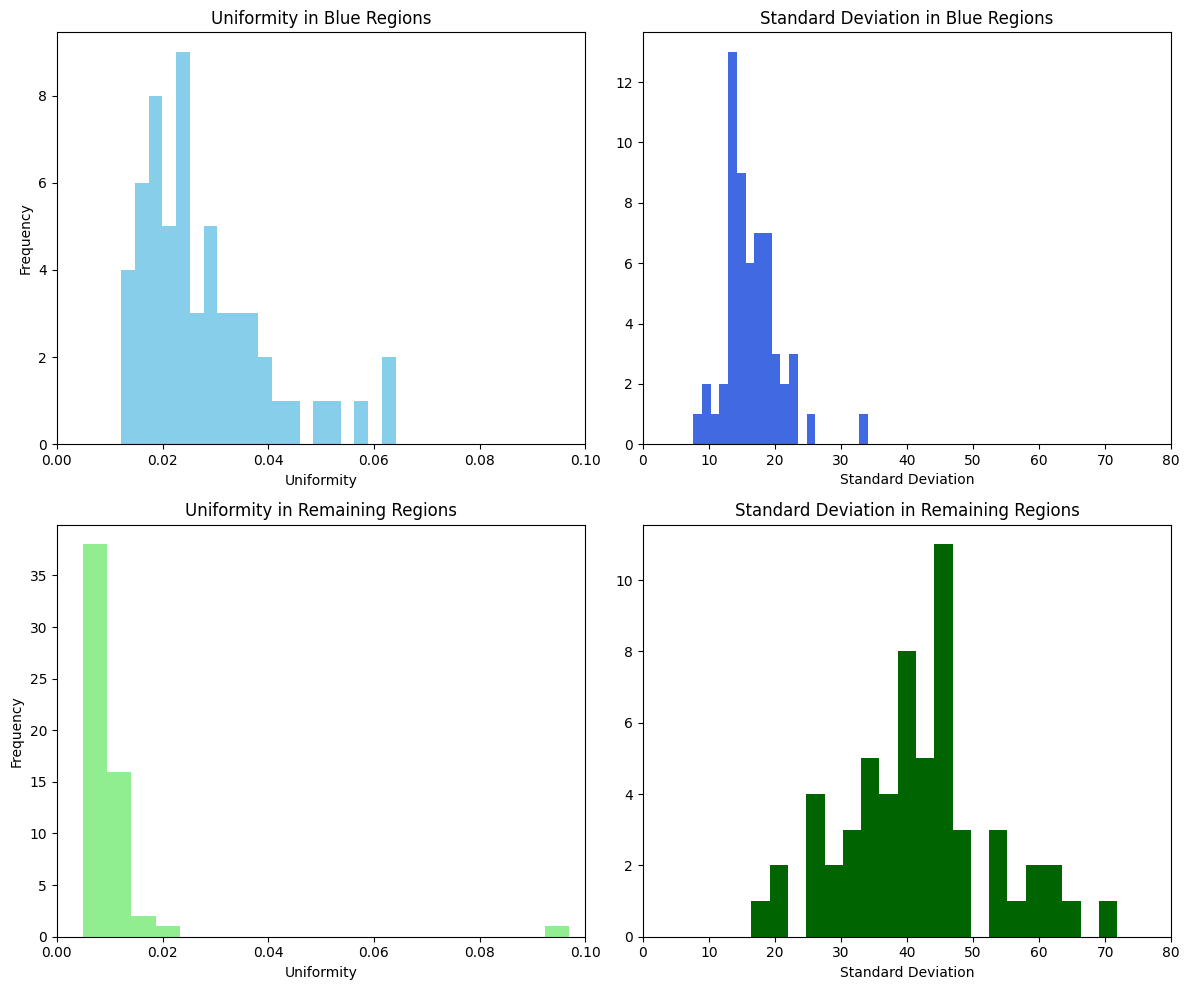

In [254]:
# -----------------------------------------------------
# Q2.2: Establish three groups in plant embryos
# -----------------------------------------------------

results = []
for img_path in img_paths:
    img_id = Path(img_path).stem
    img, embryo_mask = embryo_segmentaion(img_path)
    img_blue_only = highlight_blue_regions(img)

    img_blue_only[~embryo_mask] = 0

    blue_mask = dip.FixedThreshold(img_blue_only, 120)
    blue_mask = dip.Opening(blue_mask, dip.SE((40,40), "elliptic"))

    remain_mask = dip.Xor(embryo_mask, blue_mask)
    remain_mask = dip.Opening(remain_mask, dip.SE((20,20), "elliptic"))

    # Convert original image to grayscale
    img_gray = dip.ColorSpaceManager.Convert(img, "gray")
    img_gray = convert_to_uint8(img_gray)


    # Compute uniformity
    def compute_uniformity_and_std(img, mask):
        mask_values = np.array(img[mask])
        values, counts = np.unique(mask_values, return_counts=True)
        counts = counts / len(mask_values)

        uniformity = (counts ** 2).sum()
        std = np.std(mask_values)

        return uniformity, std
    
    uniformity_blue, std_blue = compute_uniformity_and_std(img_gray, blue_mask)
    uniformity_remain, std_remain = compute_uniformity_and_std(img_gray, remain_mask)
    
    results.append(
        {
            "Image_ID": img_id,
            "Uniformity_Blue": uniformity_blue,
            "Uniformity_Remain": uniformity_remain,
            "Std_Blue": std_blue,
            "Std_Remain": std_remain
        }
    )

features_df = pd.DataFrame(results)
features_df = features_df.set_index("Image_ID")
features_df = features_df.round(4)
display(features_df)

# Generate histograms
fig, axs = plt.subplots(2, 2, figsize=(12, 10))

# Blue region features
axs[0,0].set_xlim((0, 0.1))
axs[0,0].hist(features_df['Uniformity_Blue'], bins=20, color='skyblue')
axs[0,0].set_title('Uniformity in Blue Regions')
axs[0,0].set_xlabel('Uniformity')
axs[0,0].set_ylabel('Frequency')

axs[0,1].hist(features_df['Std_Blue'], bins=20, color='royalblue')
axs[0,1].set_xlim((0, 80))
axs[0,1].set_title('Standard Deviation in Blue Regions')
axs[0,1].set_xlabel('Standard Deviation')

# Non-blue region features
axs[1,0].set_xlim((0, 0.1))
axs[1,0].hist(features_df['Uniformity_Remain'], bins=20, color='lightgreen')
axs[1,0].set_title('Uniformity in Remaining Regions')
axs[1,0].set_xlabel('Uniformity')
axs[1,0].set_ylabel('Frequency')

axs[1,1].hist(features_df['Std_Remain'], bins=20, color='darkgreen')
axs[1,1].set_xlim((0, 80))
axs[1,1].set_title('Standard Deviation in Remaining Regions')
axs[1,1].set_xlabel('Standard Deviation')

plt.tight_layout()
plt.savefig(os.path.join(output_dir, 'texture_histograms.png'))
plt.show()